In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
import gseapy as gp
import matplotlib.pyplot as plt
import swan_vis as swan
import yaml
from snakemake.io import expand

p = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.append(p)

from scripts.utils import *
from scripts.plotting import *

In [2]:
config_file = '../snakemake/config.yml'
with open(config_file) as f:
    config = yaml.safe_load(f)

In [3]:
filt_ab = '../'+expand(config['data']['filt_ab'], species='human')[0]
lib_meta = '../'+expand(config['data']['meta'], species='human')[0]
cerberus_h5 = '../'+expand(config['data']['cerb_annot'], species='human')[0]

gene_subset = 'polya'

biosamp_name_map = '../'+expand(config['ref']['biosamp_map'])[0]

cage_meta = '../'+expand(config['cage']['meta'], species='human')[0]
rampage_meta = '../'+expand(config['rampage']['meta'], species='human')[0]

min_tpm = 1
gene_subset = 'polya'

In [4]:
def convert_encode_desc(df, col):
    """
    Convert encode desc. of a sample into something more parseable
    """
    df[col] = df[col].str.lower()
    df[col] = df[col].str.replace(', ', '_')
    df[col] = df[col].str.replace(' ', '_')
    df[col] = df[col].str.replace('-', '_')
    
    return df

In [5]:
def get_sample_names_from_dl_meta(meta_file, biosamp_map_file):
    """
    Get a list of samples present from an input ENCODE download file
    """
    df = pd.read_csv(meta_file, sep='\t')    
    df = df[['File accession', 'Experiment accession', 'Biosample term name', 'Biosample type', 'Technical replicate(s)', 'Biological replicate(s)']]
    df['classification'] = 'cell_line'
    df.loc[df['Biosample type']=='tissue', 'classification'] = 'tissue'
    df = convert_encode_desc(df, 'Biosample term name')
    
    # convert hyphenated cell line names
    term_map = pd.read_csv(biosamp_map_file, sep='\t',
                           header=None, names=['eid', 'old_name', 'idk1', 'idk2', 'new_name'])
    term_map = convert_encode_desc(term_map, 'old_name')
    term_map = convert_encode_desc(term_map, 'new_name')
    term_map = term_map[['old_name', 'new_name']]
    term_map.drop_duplicates(inplace=True)
    n1 = len(df.index)
    # print(n1)
    df = df.merge(term_map, how='left', left_on='Biosample term name', right_on='old_name')
    n2 = len(df.index)
    # print(n2)
    if n1 != n2:
        print('Duplicated thingies, check for DE samples')
    df.rename({'Biosample term name': 'sample'}, axis=1, inplace=True)
    df.loc[~df.new_name.isnull(), 'sample'] = df.loc[~df.new_name.isnull(), 'new_name']
    
    return df['sample'].unique().tolist()
    
    

In [6]:
# get the samples that we have in cage and in LR
cage_samples = get_sample_names_from_dl_meta(cage_meta, biosamp_name_map)
rampage_samples = get_sample_names_from_dl_meta(rampage_meta, biosamp_name_map)
tss_samples = set(cage_samples+rampage_samples)
lr_samples = pd.read_csv(lib_meta, sep='\t')['sample'].unique().tolist()
tss_lr_samples = list(set(lr_samples)&set(tss_samples))
tss_lr_samples

['mcf7',
 'h1',
 'k562',
 'huvec',
 'pc3',
 'imr90',
 'pgp1',
 'ocily7',
 'lung',
 'liver',
 'gm12878',
 'hepg2',
 'heart']

Calculating tss TPM values
Subsetting for ['mcf7', 'h1', 'k562', 'huvec', 'pc3', 'imr90', 'pgp1', 'ocily7', 'lung', 'liver', 'gm12878', 'hepg2', 'heart'] samples
Subsetting for polya genes


/Users/fairliereese/Documents/programming/mortazavi_lab/data/paper_rnawg/scripts/utils.py:2104: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[tpm_col] = (df[d]*1000000)/df[total_col]
/Users/fairliereese/Documents/programming/mortazavi_lab/data/paper_rnawg/scripts/utils.py:2103: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[total_col] = df[d].sum()


Enforcing minimum TPM
Total # tsss detected: 76487
# tsss >= 1 tpm: 53019
Applying gene type and novelty subset
Number of tsss reported: 51063
153941
51063
     support  counts
0      Known   43483
1      Novel    4033
2  Supported    3547
14.84% (7580/51063) of tsss are novel
46.79% (3547/7580) of novel tsss are supported



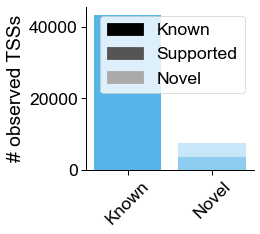

In [13]:
feat = 'tss'
ref_source = ['v29', 'v40']
support_source = ['encode_cage', 'fantom_cage', 'encode_rampage', 'pls']

plt.figure(figsize=(3,3))
sns.set_context('paper', font_scale=2)
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['pdf.fonttype'] = 42

ax = plt.gca()

plot_supported_feats_2(filt_ab=filt_ab,
                     h5=cerberus_h5,
                     feat=feat,
                     ref_sources=ref_source,
                     support_sources=support_source,
                     how=feat,
                     opref='figures/human',
                     gene_subset=gene_subset,
                     min_tpm=1,
                     ax=ax,
                     sample=tss_lr_samples)

plt.subplots_adjust(wspace=0.35)
# plt.savefig(ofile, dpi=500, layout='tight', bbox_inches='tight')

In [14]:
# what about the inverse?
# get the samples that we have in LR but NOT in cage
cage_samples = get_sample_names_from_dl_meta(cage_meta, biosamp_name_map)
rampage_samples = get_sample_names_from_dl_meta(rampage_meta, biosamp_name_map)
tss_samples = set(cage_samples+rampage_samples)
lr_samples = pd.read_csv(lib_meta, sep='\t')['sample'].unique().tolist()
tss_lr_samples = list(set(lr_samples)-set(tss_samples))
tss_lr_samples

['h9_de',
 'hct116',
 'h1_de',
 'pgp1_astro',
 'hmec',
 'pc9',
 'hl60_m1_72hr',
 'hl60_m2_24hr',
 'hl60_m2_12hr',
 'hl60_m2_72hr',
 'brain',
 'h9_osteocyte',
 'pgp1_excite_neuron',
 'caco2',
 'hl60_m1_24hr',
 'hl60_m0',
 'muscle',
 'h9_chondro',
 'a673',
 'h9',
 'h9_panc_beta',
 'hl60_m1_12hr',
 'h9_panc_progen',
 'pgp1_endo',
 'h9_neural_crest',
 'panc1',
 'ovary',
 'adipose',
 'hffc6',
 'wtc11',
 'adrenal gland',
 'hl60',
 'colon',
 'calu3',
 'vessels',
 'mcf10a',
 'kidney']

Calculating tss TPM values
Subsetting for ['h9_de', 'hct116', 'h1_de', 'pgp1_astro', 'hmec', 'pc9', 'hl60_m1_72hr', 'hl60_m2_24hr', 'hl60_m2_12hr', 'hl60_m2_72hr', 'brain', 'h9_osteocyte', 'pgp1_excite_neuron', 'caco2', 'hl60_m1_24hr', 'hl60_m0', 'muscle', 'h9_chondro', 'a673', 'h9', 'h9_panc_beta', 'hl60_m1_12hr', 'h9_panc_progen', 'pgp1_endo', 'h9_neural_crest', 'panc1', 'ovary', 'adipose', 'hffc6', 'wtc11', 'adrenal gland', 'hl60', 'colon', 'calu3', 'vessels', 'mcf10a', 'kidney'] samples
Subsetting for polya genes


/Users/fairliereese/Documents/programming/mortazavi_lab/data/paper_rnawg/scripts/utils.py:2104: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[tpm_col] = (df[d]*1000000)/df[total_col]
/Users/fairliereese/Documents/programming/mortazavi_lab/data/paper_rnawg/scripts/utils.py:2103: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[total_col] = df[d].sum()


Enforcing minimum TPM
Total # tsss detected: 76487
# tsss >= 1 tpm: 60673
Applying gene type and novelty subset
Number of tsss reported: 58268
153941
58268
     support  counts
0      Known   48639
1      Novel    5106
2  Supported    4523
16.53% (9629/58268) of tsss are novel
46.97% (4523/9629) of novel tsss are supported



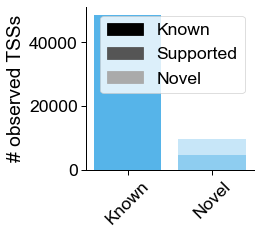

In [15]:
feat = 'tss'
ref_source = ['v29', 'v40']
support_source = ['encode_cage', 'fantom_cage', 'encode_rampage', 'pls']

plt.figure(figsize=(3,3))
sns.set_context('paper', font_scale=2)
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['pdf.fonttype'] = 42

ax = plt.gca()

plot_supported_feats_2(filt_ab=filt_ab,
                     h5=cerberus_h5,
                     feat=feat,
                     ref_sources=ref_source,
                     support_sources=support_source,
                     how=feat,
                     opref='figures/human',
                     gene_subset=gene_subset,
                     min_tpm=1,
                     ax=ax,
                     sample=tss_lr_samples)

plt.subplots_adjust(wspace=0.35)
# plt.savefig(ofile, dpi=500, layout='tight', bbox_inches='tight')

In [28]:
def get_feat_support(filt_ab,
                     h5, 
                     feat, 
                     ref_sources,
                     support_sources,
                     **kwargs):
    
    # get detected features
    df = pd.read_csv(filt_ab, sep='\t')
    df, ids = get_tpm_table(df, **kwargs)

    # get these features from cerberus
    ca = cerberus.read(h5)
    if feat == 'tss':
        ca_df = ca.tss
    elif feat == 'tes':
        ca_df = ca.tes
    elif feat == 'ic':
        ca_df = ca.ic
    print(len(ca_df.index))
    df = ca_df.loc[ca_df.Name.isin(ids)]
    print(len(df.index))


    # get T/F detection of each feat by each source
    df = upsetplot.from_memberships(df.source.str.split(','), data=df)
    df.reset_index(inplace=True)

    # which sources are observed, which are supported, and which are known
    sources = ca.get_sources(df)

    df['support'] = 'Novel'
    if support_sources:
        df.loc[df[support_sources].any(axis=1), 'support'] = 'Supported'
    df.loc[df[ref_sources].any(axis=1), 'support'] = 'Known'
    df = df[['Name', 'support']]
    
    return df
    
def plot_end_support_by_ic_novelty(filt_ab, 
                                   h5,
                                   feat,
                                   ref_sources,
                                   support_sources,
                                   min_tpm,
                                   gene_subset):
    end_df = get_feat_support(filt_ab,
                              h5, 
                              feat, 
                              ref_sources,
                              support_sources,
                              min_tpm=min_tpm,
                              gene_subset=gene_subset,
                              how=feat)
    
    # get df of transcripts that pass filtering too
    ab_df = pd.read_csv(filt_ab, sep='\t')
    ca = cerberus.read(h5)
    t_df, ids = get_tpm_table(ab_df,
                            gene_subset=gene_subset,
                            min_tpm=1,
                            how='iso')
    t_df = add_feat(t_df, kind=feat, col='index')
    t_df = add_feat(t_df, kind='ic', col='index')
    t_df = t_df.merge(ca.ic[['Name', 'novelty']], how='left', left_on='ic', right_on='Name')
    
    # merge on support info
    t_df = t_df.merge(end_df, how='left', left_on=feat, right_on='Name')    
    
    
    temp = t_df[['novelty', 'support']]
    temp.reset_index(inplace=True)
    temp = temp.groupby(['novelty', 'support']).count().reset_index().rename({'index':'n_transcripts'}, axis=1)
    
    # remove known things
    temp = temp.loc[temp.support.isin(['Novel', 'Supported'])]
    
    temp2 = temp[['novelty', 'n_transcripts']].groupby('novelty').sum().reset_index()
    
    temp2.rename({'n_transcripts':'n_total_transcripts'}, axis=1, inplace=True)
    temp = temp.merge(temp2, how='left', on='novelty')
    temp['perc'] = (temp['n_transcripts']/temp['n_total_transcripts'])*100


    # sns.barplot(data=temp, x='novelty', y='n_transcripts', hue='support')
    sns.barplot(data=temp, x='novelty', y='perc', hue='support')
    


Calculating tss TPM values
Subsetting for polya genes
Enforcing minimum TPM
Total # tsss detected: 76487
# tsss >= 1 tpm: 67730
Applying gene type and novelty subset
Number of tsss reported: 64664
153941
64664
Calculating iso TPM values
Subsetting for polya genes
Enforcing minimum TPM
Total # isos detected: 231136
# isos >= 1 tpm: 210239
Applying gene type and novelty subset
Number of isos reported: 206806


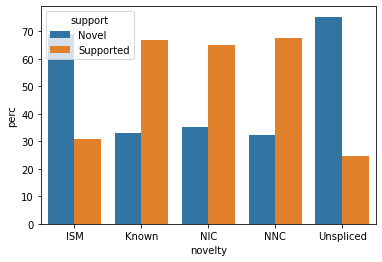

In [29]:
## What does TSS support look like for transcripts w/ ECs of different novelty?
feat = 'tss'
ref_sources = ['v29', 'v40']
support_sources = ['encode_cage', 'fantom_cage', 'encode_rampage', 'gtex']
plot_end_support_by_ic_novelty(filt_ab, 
                               cerberus_h5,
                               feat,
                               ref_sources,
                               support_sources,
                               min_tpm,
                               gene_subset)



Calculating tes TPM values
Subsetting for polya genes


/Users/fairliereese/Documents/programming/mortazavi_lab/data/paper_rnawg/scripts/utils.py:2104: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[tpm_col] = (df[d]*1000000)/df[total_col]
/Users/fairliereese/Documents/programming/mortazavi_lab/data/paper_rnawg/scripts/utils.py:2103: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[total_col] = df[d].sum()


Enforcing minimum TPM
Total # tess detected: 87670
# tess >= 1 tpm: 77369
Applying gene type and novelty subset
Number of tess reported: 74318
186735
74318
Calculating iso TPM values
Subsetting for polya genes
Enforcing minimum TPM
Total # isos detected: 231136
# isos >= 1 tpm: 210239
Applying gene type and novelty subset
Number of isos reported: 206806


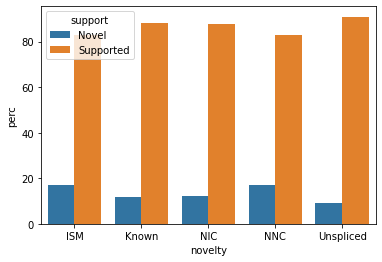

In [30]:
feat = 'tes'
ref_sources = ['v29', 'v40']
support_sources = ['pas', 'polya_atlas', 'gtex']
plot_end_support_by_ic_novelty(filt_ab, 
                               cerberus_h5,
                               feat,
                               ref_sources,
                               support_sources,
                               min_tpm,
                               gene_subset)

In [38]:
# # get df of transcripts that pass filtering too
# ab_df = pd.read_csv(filt_ab, sep='\t')
# t_df, ids = get_tpm_table(ab_df,
#                         gene_subset=gene_subset,
#                         min_tpm=1,
#                         how='iso')

Calculating iso TPM values
Subsetting for polya genes
Enforcing minimum TPM
Total # isos detected: 231136
# isos >= 1 tpm: 210239
Applying gene type and novelty subset
Number of isos reported: 206806


In [45]:
# t_df = add_feat(t_df, kind='tss', col='index')
# t_df = add_feat(t_df, kind='ic', col='index')
# t_df = t_df.merge(ca.ic[['Name', 'novelty']], how='left', left_on='ic', right_on='Name')

In [46]:
t_df.head()

,a673_1_1,a673_1_2,adrenal_gland_1_1,adrenal_gland_2_1,adrenal_gland_3_1,aorta_1_1,aorta_2_1,brodmann_area_46_1_1,brodmann_area_46_2_1,brodmann_area_46_3_1,...,right_ventricle_myocardium_inferior_1_1,right_ventricle_myocardium_superior_1_1,upper_lobe_of_right_lung_1_1,wtc11_1_1,wtc11_1_2,wtc11_1_3,tss,ic,Name,novelty
0,0.0,0.834033,0.0,0.784424,0.0,0.806143,3.184764,0.0,4.028859,2.030242,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,ENSG00000227232_1,ENSG00000227232_2,ENSG00000227232_2,NNC
1,0.0,0.000000,0.0,0.000000,0.0,0.806143,3.184764,0.0,3.021644,0.000000,...,0.000000,0.808313,1.082538,0.000000,0.959934,1.370045,ENSG00000227232_1,ENSG00000227232_3,ENSG00000227232_3,NNC
2,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,3.021644,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.959934,0.000000,ENSG00000227232_1,ENSG00000227232_4,ENSG00000227232_4,NNC
3,0.0,0.000000,0.0,0.784424,0.0,1.612287,6.369528,0.0,5.036073,0.000000,...,1.989749,3.233253,1.082538,0.564576,0.959934,0.456682,ENSG00000227232_1,ENSG00000227232_5,ENSG00000227232_5,NNC
4,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,1.082538,0.000000,0.000000,0.000000,ENSG00000227232_2,ENSG00000227232_3,ENSG00000227232_3,NNC


In [41]:
df.support.unique()

array(['Known', 'Supported', 'Novel'], dtype=object)

In [42]:
df.head()

,Name,support
0,ENSG00000000460_1,Known
1,ENSG00000000460_2,Known
2,ENSG00000000460_3,Known
3,ENSG00000000971_1,Known
4,ENSG00000000971_3,Known


In [43]:
t_df.head()

,a673_1_1,a673_1_2,adrenal_gland_1_1,adrenal_gland_2_1,adrenal_gland_3_1,aorta_1_1,aorta_2_1,brodmann_area_46_1_1,brodmann_area_46_2_1,brodmann_area_46_3_1,...,right_lobe_of_liver_1_1,right_lobe_of_liver_2_1,right_ventricle_myocardium_inferior_1_1,right_ventricle_myocardium_superior_1_1,upper_lobe_of_right_lung_1_1,wtc11_1_1,wtc11_1_2,wtc11_1_3,tss,ic
annot_transcript_id,,,,,,,,,,,,,,,,,,,,,
"ENSG00000227232[1,2,1]",0.0,0.834033,0.0,0.784424,0.0,0.806143,3.184764,0.0,4.028859,2.030242,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,ENSG00000227232_1,ENSG00000227232_2
"ENSG00000227232[1,3,1]",0.0,0.000000,0.0,0.000000,0.0,0.806143,3.184764,0.0,3.021644,0.000000,...,0.0,0.0,0.000000,0.808313,1.082538,0.000000,0.959934,1.370045,ENSG00000227232_1,ENSG00000227232_3
"ENSG00000227232[1,4,1]",0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,3.021644,0.000000,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.959934,0.000000,ENSG00000227232_1,ENSG00000227232_4
"ENSG00000227232[1,5,1]",0.0,0.000000,0.0,0.784424,0.0,1.612287,6.369528,0.0,5.036073,0.000000,...,0.0,0.0,1.989749,3.233253,1.082538,0.564576,0.959934,0.456682,ENSG00000227232_1,ENSG00000227232_5
"ENSG00000227232[2,3,1]",0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.000000,0.000000,1.082538,0.000000,0.000000,0.000000,ENSG00000227232_2,ENSG00000227232_3


In [47]:
t_df = t_df.merge(df, how='left', left_on='tss', right_on='Name')

In [48]:
t_df.head()

,a673_1_1,a673_1_2,adrenal_gland_1_1,adrenal_gland_2_1,adrenal_gland_3_1,aorta_1_1,aorta_2_1,brodmann_area_46_1_1,brodmann_area_46_2_1,brodmann_area_46_3_1,...,upper_lobe_of_right_lung_1_1,wtc11_1_1,wtc11_1_2,wtc11_1_3,tss,ic,Name_x,novelty,Name_y,support
0,0.0,0.834033,0.0,0.784424,0.0,0.806143,3.184764,0.0,4.028859,2.030242,...,0.000000,0.000000,0.000000,0.000000,ENSG00000227232_1,ENSG00000227232_2,ENSG00000227232_2,NNC,ENSG00000227232_1,Known
1,0.0,0.000000,0.0,0.000000,0.0,0.806143,3.184764,0.0,3.021644,0.000000,...,1.082538,0.000000,0.959934,1.370045,ENSG00000227232_1,ENSG00000227232_3,ENSG00000227232_3,NNC,ENSG00000227232_1,Known
2,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,3.021644,0.000000,...,0.000000,0.000000,0.959934,0.000000,ENSG00000227232_1,ENSG00000227232_4,ENSG00000227232_4,NNC,ENSG00000227232_1,Known
3,0.0,0.000000,0.0,0.784424,0.0,1.612287,6.369528,0.0,5.036073,0.000000,...,1.082538,0.564576,0.959934,0.456682,ENSG00000227232_1,ENSG00000227232_5,ENSG00000227232_5,NNC,ENSG00000227232_1,Known
4,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,...,1.082538,0.000000,0.000000,0.000000,ENSG00000227232_2,ENSG00000227232_3,ENSG00000227232_3,NNC,ENSG00000227232_2,Novel


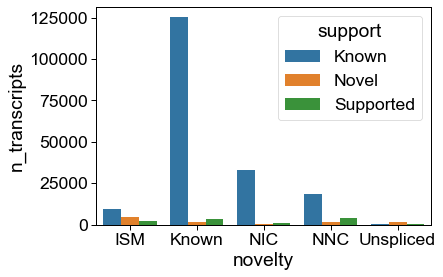

In [50]:

temp = t_df[['novelty', 'support']]
temp.reset_index(inplace=True)
temp = temp.groupby(['novelty', 'support']).count().reset_index().rename({'index':'n_transcripts'}, axis=1)

sns.barplot(data=temp, x='novelty', y='n_transcripts', hue='support')